<a href="https://colab.research.google.com/github/samthomaz/forage-jpmc-swe-task-1/blob/main/skin_cancer_detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Google Colab Setup and Loading Dataset**

In [31]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"samuelthomas5","key":"d3d838d7e15edadd40a0e35fcfeb9e42"}'}

In [32]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Download HAM10000 Dataset
!kaggle datasets download kmader/skin-cancer-mnist-ham10000
!ls
!unzip skin-cancer-mnist-ham10000.zip
!ls

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
User cancelled operation
 ham10000_images_part_1   hmnist_28_28_L.csv	 kaggle.json
 HAM10000_images_part_1   hmnist_28_28_RGB.csv	 sample_data
 ham10000_images_part_2   hmnist_8_8_L.csv	 skin-cancer-mnist-ham10000.zip
 HAM10000_images_part_2   hmnist_8_8_RGB.csv
 HAM10000_metadata.csv	 'kaggle (1).json'
Archive:  skin-cancer-mnist-ham10000.zip
replace HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1/ISIC_0024307.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1/ISIC_0024308.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1/ISIC_0024309.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1/ISIC_0024310.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1/ISIC_0024311.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10

 ham10000_images_part_1   hmnist_28_28_L.csv	 kaggle.json
 HAM10000_images_part_1   hmnist_28_28_RGB.csv	 sample_data
 ham10000_images_part_2   hmnist_8_8_L.csv	 skin-cancer-mnist-ham10000.zip
 HAM10000_images_part_2   hmnist_8_8_RGB.csv
 HAM10000_metadata.csv	 'kaggle (1).json'
Total images:  10015


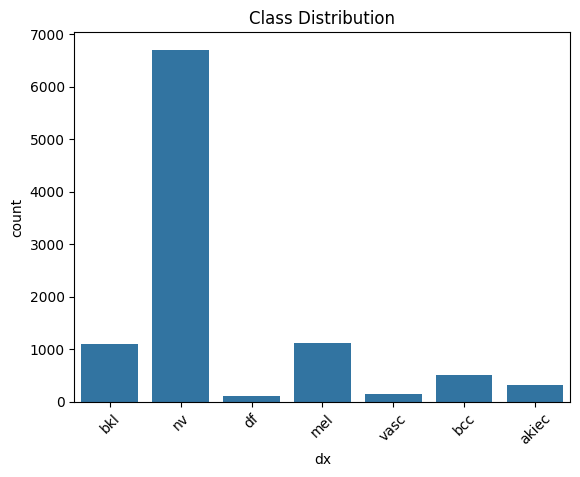

In [39]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

!ls

df = pd.read_csv('HAM10000_metadata.csv')
df.head()

print("Total images: ", len(df))

sns.countplot(x='dx', data=df)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [40]:
df['label'] = df['dx'].apply(lambda x: 1 if x == 'mel' else 0)
print(df['label'].value_counts())

label
0    8902
1    1113
Name: count, dtype: int64


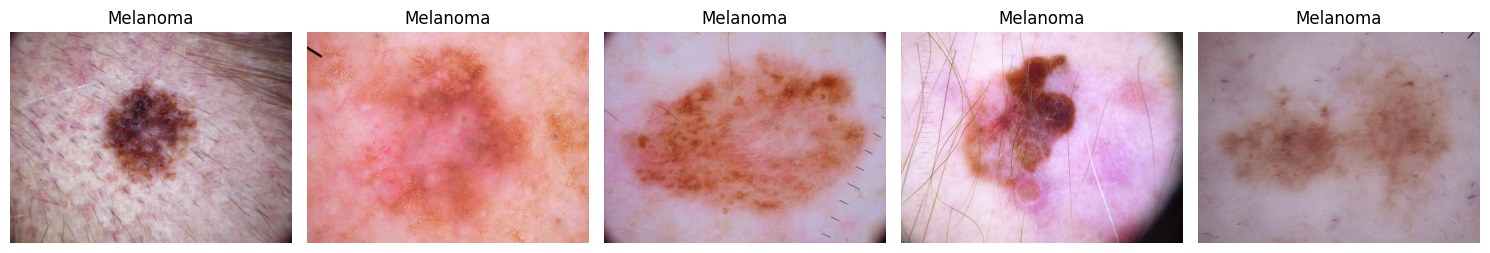

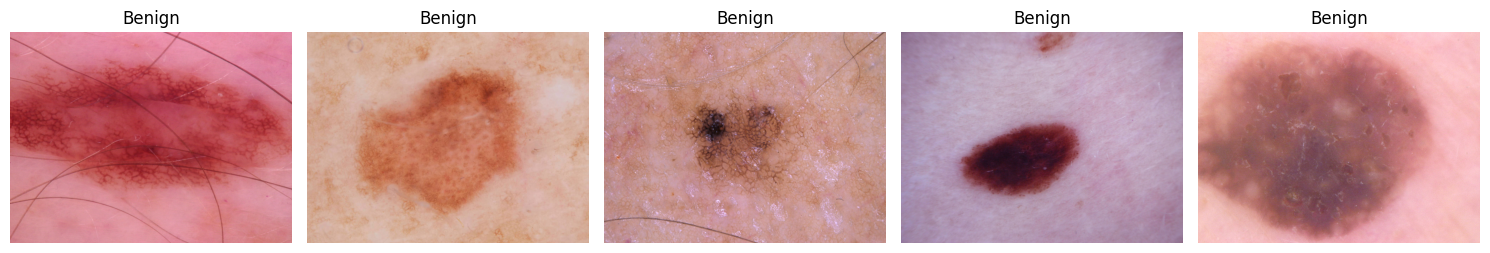

In [41]:
import matplotlib.pyplot as plt

def show_images(df, label, n=5):
  subset = df[df['label'] == label].sample(n)
  plt.figure(figsize=(15, 5))
  for i, row in enumerate(subset.itertuples()):
    image_path = os.path.join('HAM10000_images_part_1', row.image_id + '.jpg')
    if not os.path.exists(image_path):
      image_path = os.path.join('HAM10000_images_part_2', row.image_id + '.jpg')
    image = Image.open(image_path)
    plt.subplot(1, n, i+1)
    plt.imshow(image)
    plt.title('Melanoma' if row.label == 1 else 'Benign')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

show_images(df, label=1) # Melanoma
show_images(df, label=0) # Benign

# **Preprocessing & Dataset Preparation**

In [42]:
import os

#Code block will aid to get the correct image path
def get_image_path(image_id):
  part1 = os.path.join('HAM10000_images_part_1', image_id + '.jpg')
  part2 = os.path.join('HAM10000_images_part_2', image_id + '.jpg')
  return part1 if os.path.exists(part1) else part2

df['image_path'] = df['image_id'].apply(get_image_path)

df[['image_id', 'image_path', 'label']].head()

,image_id,image_path,label
0,ISIC_0027419,HAM10000_images_part_1/ISIC_0027419.jpg,0
1,ISIC_0025030,HAM10000_images_part_1/ISIC_0025030.jpg,0
2,ISIC_0026769,HAM10000_images_part_1/ISIC_0026769.jpg,0
3,ISIC_0025661,HAM10000_images_part_1/ISIC_0025661.jpg,0
4,ISIC_0031633,HAM10000_images_part_2/ISIC_0031633.jpg,0


In [43]:
mel_df = df[df['label'] == 1]
non_mel_df = df[df['label'] == 0].sample(len(mel_df), random_state=42)

balanced_df = pd.concat([mel_df, non_mel_df]).sample(frac=1).reset_index(drop=True)
print(balanced_df['label'].value_counts())

label
1    1113
0    1113
Name: count, dtype: int64


In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255, #normalises image pixels from 0-255 to 0-1
    validation_split=0.2, #rsvs 20% of data for validation
    horizontal_flip=True, #adds data augmentation to make model more robust
    rotation_range=15,
    zoom_range=0.1
)

#creates batches of images and labels for training and validation sets
train_gen = datagen.flow_from_dataframe(
    balanced_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='training',
    shuffle=True
  )


validation_gen = datagen.flow_from_dataframe(
    balanced_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='validation',
    shuffle=True
)

Found 1781 validated image filenames.
Found 445 validated image filenames.


# **Building and Training CNN model with Transfer Learning**

Transfer learning reuses "early layers" of pre-trained model (which detects edges, shapes, colours) and adds user defined custom output layer for the case (in this instance it is the melanoma detection).

MobielNetV2 will be used since

In [63]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Loading the base MobileNetV2 model (without top layers)
base_model = MobileNetV2(input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3),
                         include_top =  False, #not to include ImageNet classification head
                         weights = 'imagenet') # use weights learnt from imagenet

#Freeze the base layers to only train the new top layers
base_model.trainable = False

In [64]:
#Adding Custom Layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [65]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)

In [66]:
history = model.fit(
    train_gen,
    validation_data = validation_gen,
    epochs = 10,
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5775 - loss: 0.7910

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.5775 - loss: 0.7903 - val_accuracy: 0.6562 - val_loss: 0.5921
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6357 - loss: 0.6687 - val_accuracy: 0.6831 - val_loss: 0.5686
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6659 - loss: 0.6251 - val_accuracy: 0.7034 - val_loss: 0.5433
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.7055 - loss: 0.5792 - val_accuracy: 0.7191 - val_loss: 0.5372
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.6970 - loss: 0.5765 - val_accuracy: 0.7101 - val_loss: 0.5268
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7330 - loss: 0.5373 - val_accuracy: 0.7281 - val_loss: 0.5256
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7268 - loss: 0.5421 - val_accuracy: 0.7303 - val_loss: 0.5279
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.7249 - loss: 0.5327 - val_accuracy: 0.7528 - val_loss: 0.

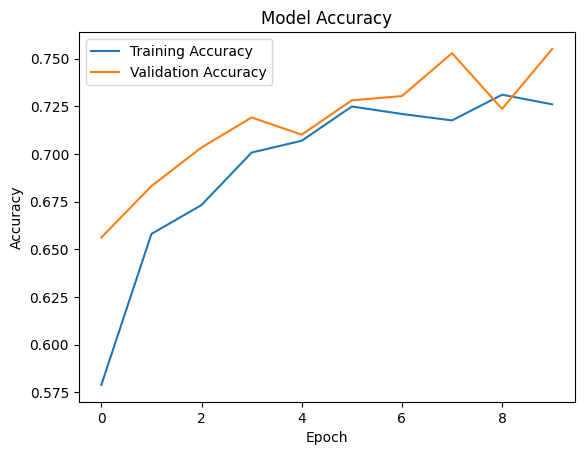

In [67]:
import matplotlib.pyplot as plt

#Accuracy plot
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Evaluate and Interpret the Model**

In [ ]:
import numpy as np

#Reset valuation_gen, so that it will start from the beginning
